In [1]:
include("..\\modified_sindy.jl"); 

## Generating Data

In [2]:
function Lorenz(du, u, p, t)
    #  p: Parameter vector.
    # du: Derivative of the system (left-hand side).
    #  u: State of the system.
    #  t: Time index.
    # return du: Derivative of system.
    #--------------------------- 
    du[1] = p[1]*(u[2]-u[1])
    du[2] = u[1]*(p[2]-u[3])-u[2]
    du[3] = u[1]*u[2]-p[3]*u[3] 
     
    return du
     
 end
 

Lorenz (generic function with 1 method)

In [3]:
# Define time step
dt=0.01

# Define final time
T1=25

# Define time horizon
tspan1=(0.0,T1)

# Define initial condition
u0=[5.0;5.0;25.0]

# Define parameters for simulating the 
p0=[10.0;28.0;8/3]

# Define the ODE problem
prob = ODEProblem(Lorenz,u0,tspan1,p0)

# Solve the ODE problem and get the clean data 
u=transpose(Array(solve(prob,saveat=dt)));

In [4]:
function add_noise(NoiseLevel, u, dt)
    # Define the random seed
    Random.seed!(0)

    # Calculate noise magnitude
    NoiseMag=NoiseLevel*std(u,dims=1)/100

    # Generate noise
    Noise=NoiseMag.*randn(size(u))

    # Now, add the noise to the clean data to generate the noisy measurment data
    un=u+Noise;

    dun=CalDerivative(un,dt)

    # Discard the first and last two points
    un=un[3:end-2,:];
    Noise=Noise[3:end-2,:];
    return un, dun, Noise
end

add_noise (generic function with 1 method)

In [5]:
un, dun, Noise = add_noise(20, u, dt);

## Handling Noise

This is our noisy data at 20% noise level

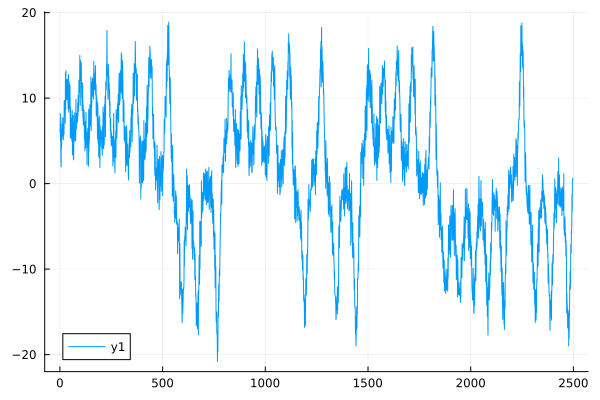

In [6]:
using Plots
plot(un[:, 1])

With no smoothing or interpolation, this is what the derivatives look like

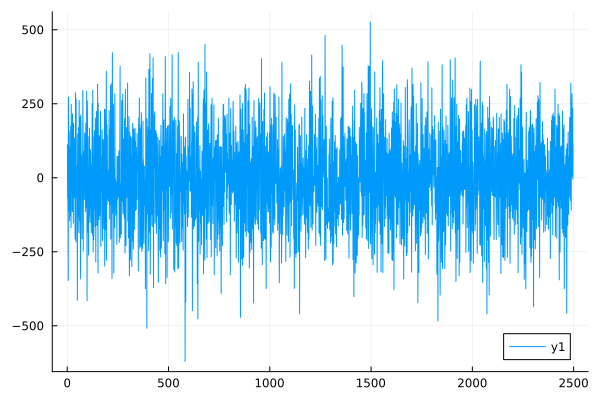

In [7]:
plot(dun[:, 1])

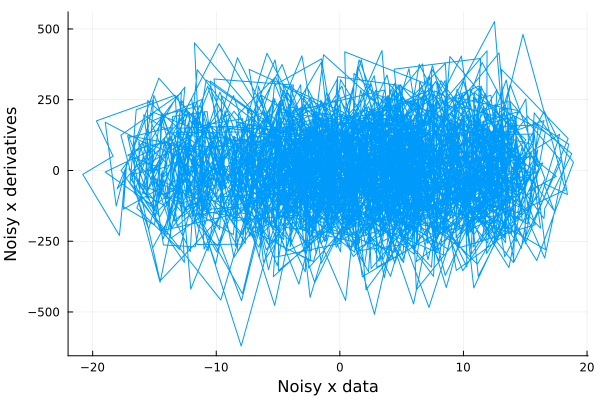

In [8]:
plot(un[:, 1], dun[:, 1], xlabel = "Noisy x data", ylabel = "Noisy x derivatives", label = false)

For reference, this is what we should be getting

In [9]:
i = 1
plot(u[:,i][3:end-2,:], du[:, i], xlabel = "x data", ylabel = "x derivatives", label = false)

UndefVarError: UndefVarError: du not defined

In [10]:
using NoiseRobustDifferentiation
des = tvdiff(un[:, 1], 10, 1e12, dx=dt)
for i in 2:size(un)[2]
    des = hcat(des, tvdiff(un[:, i], 10, 1e2, dx=dt))
end

Using NoiseRobustDifferentiation gives excellent results

In [11]:
plot(du[:, 1], label = "True")
plot!(des[:, 1], label = "Estimated")

UndefVarError: UndefVarError: du not defined

Still useless unless we also smooth the original data

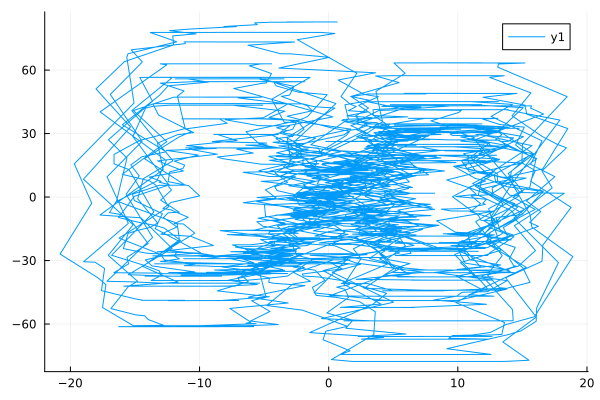

In [12]:
i = 1
plot(un[:, i], des[:, i])

In [13]:
using RollingFunctions
ues = runmean(un[:, 1], 10)
for i in 2:size(un)[2]
    ues = hcat(ues, runmean(un[:, i], 10))
end

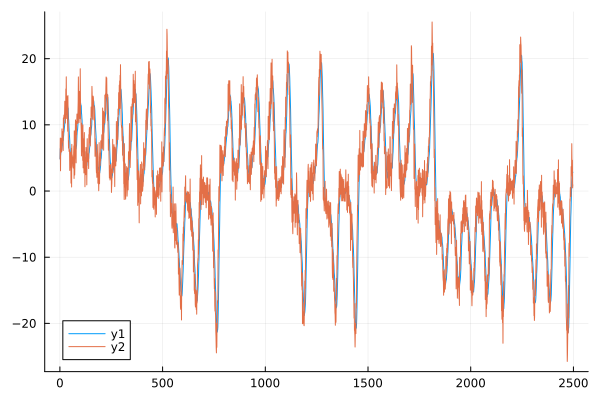

In [14]:
#plot(un[:, 1])
i = 2
plot(ues[:, i])
plot!(un[:, i])

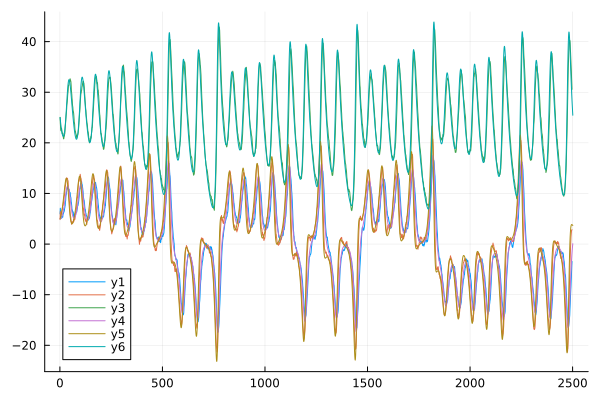

In [15]:
plot(ues)
plot!(u)

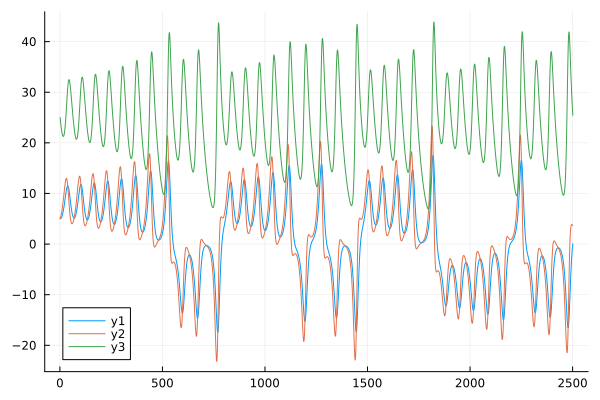

In [16]:
plot(u)

In [17]:
function simple_smoothing(un, dun, dt)
    dues = tvdiff(un[:, 1], 10, 1e12, dx=dt)
    for i in 2:size(un)[2]
        dues = hcat(dues, tvdiff(un[:, i], 10, 1e2, dx=dt))
    end
    ues = runmean(un[:, 1], 10)
    for i in 2:size(un)[2]
        ues = hcat(ues, runmean(un[:, i], 10))
    end
    return ues, dues
end

simple_smoothing (generic function with 1 method)

## SINDy

In [25]:
pow_stable(a, b) = sign.(a) .* abs.(a) .^ b

function Lib(u, x)
    # u: The measuremt state matrix with size n x m, where n is the data length, m is the number of states. 
    # return Θ: Library matrix, with size of n x p, where p is the number of candidate terms in the library. 
    #---------------------------
    u1_x1 = pow_stable.(u[:,1], x[1])
    u2_x2 = pow_stable.(u[:,2], x[2])
    u3_x3 = pow_stable.(u[:,3], x[3])
    Θ=[u1_x1 u2_x2 u3_x3 u1_x1.*u2_x2 u1_x1.*u3_x3 u2_x2.*u3_x3]
    #Θ=[pow_stable.(u[:,1], x[1]) pow_stable.(u[:,2], x[2]) pow_stable.(u[:,3], x[3]) pow_stable.(u[:,1], x[1]).*pow_stable.(u[:,2], x[2]) pow_stable.(u[:,1], x[1]).*pow_stable.(u[:,3], x[3]) pow_stable.(u[:,2], x[2]).*pow_stable.(u[:,3], x[3])]
    return Θ
end

Lib (generic function with 1 method)

In [131]:
Lib_2(u) = Lib(u, [1.,1.,1.])
λms=exp.(-10:0.1:-0.1)
iter=10
problem = SINDy_Problem(ues, des, Lib_2, λms, iter)
problem.ρ = 1000
m, l = solve_SINDy(problem)
m

6×3 Matrix{Float64}:
 -2.59025   12.2283     0.0
  8.44983    6.48962    0.0
  0.0        0.0       -2.352
  0.0        0.0        0.784998
 -0.115693  -0.400845   0.0
 -0.121517  -0.372306   0.0

In [17]:
x0 = [0.5, 0.5, 0.5]
ADType = Optimization.AutoFiniteDiff()
opt = NelderMead()
lb = [0.3, 0.3, 0.3]
ub = [2.0, 2.0, 2.0]
alg = OLE(x0, ADType, opt, lb, ub)

λs=exp.(-10:0.1:-0.1)
iter=10
prob = SINDy_Problem(un, dun, dt, Lib, λs, iter, alg)
m, l, x = solve_SINDy(prob)
x

3-element Vector{Float64}:
 0.9986658263161919
 0.9991533157320776
 0.998121314660126

In [38]:
opt = SAMIN()
alg = OLE(x0, ADType, opt, lb, ub)
prob = SINDy_Problem(un, dun, dt, Lib, λs, iter, alg)
m, l, x = solve_SINDy(prob)
x

SAMIN results
NO CONVERGENCE: MAXEVALS exceeded

     Obj. value:        4952.84160

       parameter      search width
         0.99811           1.70000 
         1.00048           1.70000 
         0.99608           1.70000 


3-element Vector{Float64}:
 0.9981052633334756
 1.0004768296566358
 0.9960841439080325

In [22]:
opt = SimulatedAnnealing()
alg = OLE(x0, ADType, opt)
prob = SINDy_Problem(un, dun, dt, Lib, λs, iter, alg)
m, l, x = solve_SINDy(prob)
x

3-element Vector{Float64}:
 1.023872289453303
 1.1066352145766658
 1.0948663667989833

## Test Noise Values

In [33]:
function test_noise(NoiseLevel, u, dt)
    un, dun, Noise = add_noise(NoiseLevel, u, dt);
    ues, dues = simple_smoothing(un, dun, dt)

    x0 = [0.5, 0.5, 0.5]
    ADType = Optimization.AutoFiniteDiff()
    opt = NelderMead()
    lb = [0.3, 0.3, 0.3]
    ub = [2.0, 2.0, 2.0]
    alg = OLE(x0, ADType, opt, lb, ub)

    λs=exp.(-10:0.1:-0.1)
    iter=10
    prob = SINDy_Problem(un, dun, dt, Lib, λs, iter, alg)
    return solve_SINDy(prob)
end

test_noise (generic function with 1 method)

In [38]:
m, l, x = test_noise(1, u, dt)
print(x)
m

[0.9985336605852826, 1.001360830971303, 0.9986487538649037]

6×3 Matrix{Float64}:
 -10.0272   27.9928     0.0
   9.96544  -0.957737   0.0
   0.0       0.0       -2.67566
   0.0       0.0        0.997875
   0.0      -1.00556    0.0
   0.0       0.0        0.0

In [39]:
m, l, x = test_noise(2, u, dt)
print(x)
m

[1.0016537422679253, 1.004592601825075, 1.006836925022896]

6×3 Matrix{Float64}:
 -9.92822  27.1168      -0.012806
  9.8679   -0.670578     0.0117978
  0.0       0.0         -2.5973
  0.0       0.0          0.979264
  0.0      -0.951085     0.0
  0.0      -0.00717824   0.0

In [40]:
m, l, x = test_noise(5, u, dt)
print(x)
m

[1.0083299901451348, 1.0150614192644352, 1.027011977423364]

6×3 Matrix{Float64}:
 -9.60198  23.6852    -0.0434184
  9.47867   0.832311   0.0414031
  0.0       0.0       -2.40511
  0.0       0.0        0.92767
  0.0      -0.795168   0.0
  0.0      -0.041993   0.0

In [41]:
m, l, x = test_noise(10, u, dt)
print(x)
m

[0.9600442084955962, 1.0369963306176238, 1.0153682004035427]

6×3 Matrix{Float64}:
 -4.0406     21.4884     -1.91692
  6.3341      3.25117     1.01131
  0.0         0.0318382  -2.45183
  0.0         0.0         0.968615
 -0.157985   -0.798063    0.0487742
  0.0425961  -0.102288   -0.0247465

In [47]:
m, l, x = test_noise(6, u, dt)
print(x)
m

[1.0086203272557288, 1.016901200297899, 1.0284215646752184]

6×3 Matrix{Float64}:
 -9.51295  22.646      -0.0589865
  9.3692    1.39053     0.0550069
  0.0       0.0        -2.38632
  0.0       0.0         0.919321
  0.0      -0.765168    0.0
  0.0      -0.0546722   0.0